## Steps for performing the analysis:
1. Get Postal Codes and Zip Codes for Downtown Toronto and Fort Myers
2. Get the latitudes and longitudes for both cities
3. Get the facilities in both cities
    3.1 Shortlist the facilities and services into the essentials for retirees (Filter for Venue Category in Foursquare API is required)
        3.1.1 Health Care
        3.1.2 Transportation and Travel
        3.1.3 Government and Public Services
        3.1.4 Amenities
        3.1.5 Art, Culture and community
4. Use the scoring model similar to the one used by Maclean's: https://www.macleans.ca/economy/best-communities-in-canada-2019-methodology/, and get the ranking of each categories for comparison


In [1]:
# 1. Installing packages / Importing libraries
!pip install beautifulsoup4
!pip install lxml
!easy_install -m  lxml

Searching for lxml
Best match: lxml 4.5.2

Using /home/jupyterlab/conda/envs/python/lib/python3.6/site-packages
Because this distribution was installed --multi-version, before you can
import modules from this package in an application, you will need to
'import pkg_resources' and then use a 'require()' call similar to one of
these examples, in order to select the desired version:

    pkg_resources.require("lxml")  # latest installed version
    pkg_resources.require("lxml==4.5.2")  # this exact version
    pkg_resources.require("lxml>=4.5.2")  # this version or higher

Processing dependencies for lxml
Finished processing dependencies for lxml


In [2]:
# Install python geocoder
!pip install geocoder

In [3]:
# For reading Excel file
!pip install xlrd

In [4]:
import json # library to handle JSON files

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

In [5]:
!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('folium imported.')

Solving environment: done

# All requested packages already installed.

folium imported.


In [6]:
!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

print('geopy imported.')

Solving environment: done

# All requested packages already installed.

geopy imported.


In [7]:
# Import Library
import numpy as np 
import pandas as pd
import requests
import json
from pandas.io.json import json_normalize
from bs4 import BeautifulSoup
import lxml
import lxml.etree

# import geocoder
import geocoder

In [8]:
# Defining Foursquare API credential
# @hidden_cell

CLIENT_ID = '0YEC5AQWOTDYWPW1CMA4ZGYILP4I3RZ2NBQIEDA0AVH1W1QQ' # your Foursquare ID
CLIENT_SECRET = 'DNRKE0ZZGKS5Z4V0VZ5BWCLK5P3E3DW0VFDCUKOVMM1H5OG3' # your Foursquare Secret
VERSION = '20200715' # Foursquare API version

LIMIT = 100

## Step 2: Get the geographical locations in Downtown Toronto regions

In [9]:
# 2.1 Get all postal codes for Toronto
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
res = requests.get(url)
soup = BeautifulSoup(res.content)
raw_tables_contents = soup.table.find_all("tr")

In [10]:
# 2.2 transforming data from tables_contents into df
columns_label = raw_tables_contents[0].get_text().replace(" ", "")
columns_label_list = list(filter(None, columns_label.split('\n')))
postal_codes_df = pd.DataFrame(columns=columns_label_list)

In [11]:
# 2.3 assigning data into the df
raw_data = raw_tables_contents[1:]
for idx, row in enumerate(raw_data):
   data_row = list(filter(None, row.get_text().split('\n')))
   postal_codes_df.loc[idx] = data_row

In [12]:
# 2.4 Cleaning the df
postal_codes_df = postal_codes_df[postal_codes_df.Borough != 'Not assigned']
postal_codes_df.reset_index(drop=True, inplace=True)
postal_codes_df

,PostCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North"
99,M4Y,Downtown Toronto,Church and Wellesley
100,M7Y,East Toronto,"Business reply mail Processing Centre, South C..."
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu..."


In [13]:
# 2.5 Read the csv file to obtain the postal code to latitde/longitude mapping
geo_partial_data = pd.DataFrame()
geo_partial_data = pd.read_csv("Geospatial_data.csv", delimiter=",", names=['PostalCode', 'Latitude', 'Longitude'])
geo_partial_data = geo_partial_data.iloc[1:]
geo_partial_data

,PostalCode,Latitude,Longitude
1,M1B,43.8066863,-79.1943534
2,M1C,43.7845351,-79.1604971
3,M1E,43.7635726,-79.1887115
4,M1G,43.7709921,-79.2169174
5,M1H,43.773136,-79.2394761
...,...,...,...
99,M9N,43.706876,-79.5181884
100,M9P,43.696319,-79.5322424
101,M9R,43.6889054,-79.5547244
102,M9V,43.7394164,-79.5884369


In [14]:
# 2.6 Join two dataframes to get the geographical locations according to Toronto postal code
# pc_geo_df = postal_codes_df.join(geo_partial_data, how='inner', on='PostalCode')
pc_geo_df = postal_codes_df.set_index('PostCode').join(geo_partial_data.set_index('PostalCode'), how='inner')
# df.set_index('key').join(other.set_index('key'))
# pc_geo_df = pd.merge(postal_codes_df, geo_partial_data, how='inner', left_on='PostalCode', right_on='PostCode')
pc_geo_df.Latitude = pc_geo_df.Latitude.astype(float)
pc_geo_df.Longitude = pc_geo_df.Longitude.astype(float)

toronto_df = pc_geo_df[pc_geo_df['Borough'].str.upper().str.contains('DOWNTOWN TORONTO')]
toronto_df.reset_index(drop=True, inplace=True)
toronto_df.head()


,Borough,Neighborhood,Latitude,Longitude
0,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
1,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
2,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
3,Downtown Toronto,St. James Town,43.651494,-79.375418
4,Downtown Toronto,Berczy Park,43.644771,-79.373306


## 3. Get the grographical locations in Fort Myers locations
(Source: https://public.opendatasoft.com/)

In [15]:
# 3.1 Fort Myers's latitudes and longitudes are retrieved from external sources: https://public.opendatasoft.com/
fort_myers_df = pd.read_csv("us-zip-code-latitude-and-longitude.csv", delimiter=";")
fort_myers_df.drop(['City', 'State', 'Timezone', 'Daylight savings time flag', 'geopoint'], axis=1, inplace=True)
fort_myers_df.head()

,Zip,Latitude,Longitude
0,33994,26.552895,-81.94861
1,33912,26.501582,-81.82841
2,33907,26.566053,-81.87009
3,33905,26.680407,-81.74812
4,33908,26.502677,-81.93052


## 4.1 Create the map of Downtown Toronto with the locations from #2


In [31]:
# 4.1 Create map of Downtown Toronto
address = 'Toronto'
geolocator = Nominatim(user_agent="tor_explorer")
location = geolocator.geocode(address)
tor_latitude = location.latitude
tor_longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(tor_latitude, tor_longitude))

# create map of Downtown Toronto
map_toronto = folium.Map(width=800, height=700, location=[tor_latitude, tor_longitude], zoom_start=13)

# add markers to map
for lat, lng, borough, neighborhood in zip(toronto_df['Latitude'], toronto_df['Longitude'], toronto_df['Borough'], toronto_df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)
    
map_toronto

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


## 4.2 Create the map of Fort Myers with the locations from #3


In [50]:
# 4.1 Create map of Fort Myers
address = 'Fort Myers'
geolocator = Nominatim(user_agent="fm_explorer")
location = geolocator.geocode(address)
fm_latitude = location.latitude
fm_longitude = location.longitude
print('The geograpical coordinate of Fort Myers are {}, {}.'.format(tor_latitude, tor_longitude))

# create map of Fort Myers
map_fm = folium.Map(width=800, height=700, location=[fm_latitude, fm_longitude], zoom_start=11)

# add markers to map
for lat, lng, borough, neighborhood in zip(fort_myers_df['Latitude'], fort_myers_df['Longitude'], fort_myers_df['Zip'], fort_myers_df['Zip']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_fm)
    
map_fm

The geograpical coordinate of Fort Myers are 43.6534817, -79.3839347.


## 5. Search all available venues
### Create a function to iteratively search the nearby venue based on latitudes and longitudes

In [33]:

def searchVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print("Processing: ", name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['venues']
        
        for v in results:
            # for v in results:
            if(len(v['categories']) == 1):
                venues_list.append([(
                    v['name'], 
                    v['location']['lat'], 
                    v['location']['lng'],  
                    v['categories'][0]['name'])])
            else:
                venues_list.append([(
                    v['name'], 
                    v['location']['lat'], 
                    v['location']['lng'],  
                    'NA')])
        
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = [
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [34]:
toronto_search_venue = searchVenues(names=toronto_df['Neighborhood'], latitudes=toronto_df['Latitude'], longitudes=toronto_df['Longitude'])
toronto_search_venue.shape

Processing:  Regent Park, Harbourfront
Processing:  Queen's Park, Ontario Provincial Government
Processing:  Garden District, Ryerson
Processing:  St. James Town
Processing:  Berczy Park
Processing:  Central Bay Street
Processing:  Christie
Processing:  Richmond, Adelaide, King
Processing:  Harbourfront East, Union Station, Toronto Islands
Processing:  Toronto Dominion Centre, Design Exchange
Processing:  Commerce Court, Victoria Hotel
Processing:  University of Toronto, Harbord
Processing:  Kensington Market, Chinatown, Grange Park
Processing:  CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
Processing:  Rosedale
Processing:  Stn A PO Boxes
Processing:  St. James Town, Cabbagetown
Processing:  First Canadian Place, Underground city
Processing:  Church and Wellesley


(1775, 4)

## 5.2 Search the venues in Fort Myers

In [35]:
fm_search_venue = searchVenues(names=fort_myers_df['Zip'],
                               latitudes=fort_myers_df['Latitude'],
                               longitudes=fort_myers_df['Longitude']
                              )

fm_search_venue.shape

Processing:  33994
Processing:  33912
Processing:  33907
Processing:  33905
Processing:  33908
Processing:  33917
Processing:  33931
Processing:  33913
Processing:  33911
Processing:  33901
Processing:  33961
Processing:  33903
Processing:  33965
Processing:  33919
Processing:  33932
Processing:  33916
Processing:  33902
Processing:  33906
Processing:  33918


(1847, 4)

## 6. Get the ranking for every category type
#### An inclusive list (all_categories_final.xlsx) has been created with 5 category types:
    Type 1: Health Care
    Type 2: Transportation and Travel
    Type 3: Government and Public Services
    Type 4: Amenities
    Type 5: Art, Culture and Community
    
    Ranking for the aforementioned 5 types is done based on the methodology suggested in Maclean's "Best communities in Canada 2019" study, with slight modifications. The ranking is as follows:
    Type 1: 20 points
    Type 2: 10 points
    Type 3: 2.5 points
    Type 4: 2.5 points
    Type 5: 5 points
    
    The inclusive list contains 2 columns: CategoryName and CategoryType: CategoryName is drawn based on the venue category in Foursquare API; CategoryType is the affiliated type of the cateogry based on the aforementioned list.

## 6.1 Get the ranking score for both cities

In [37]:
# Read the xlsx file
all_cat_df = pd.read_excel('all_categories_final.xlsx')

# Data cleansing for gibberish text in imported xlsx file
# CafÃ© -> Café
all_cat_df['Venue Category'] = all_cat_df['Venue Category'].str.replace('CafÃ©', 'Café')

In [38]:
# For Toronto
toronto_types_ranking = []
toronto_types_ranking.append(len(pd.merge(toronto_search_venue, all_cat_df[all_cat_df['Venue Category Type']==1], how='inner', on='Venue Category')) * 20)
toronto_types_ranking.append(len(pd.merge(toronto_search_venue, all_cat_df[all_cat_df['Venue Category Type']==2], how='inner', on='Venue Category')) * 10)
toronto_types_ranking.append(len(pd.merge(toronto_search_venue, all_cat_df[all_cat_df['Venue Category Type']==3], how='inner', on='Venue Category')) * 2.5)
toronto_types_ranking.append(len(pd.merge(toronto_search_venue, all_cat_df[all_cat_df['Venue Category Type']==4], how='inner', on='Venue Category')) * 2.5)
toronto_types_ranking.append(len(pd.merge(toronto_search_venue, all_cat_df[all_cat_df['Venue Category Type']==5], how='inner', on='Venue Category')) * 5)

In [39]:
toronto_types_ranking

[1420, 1210, 322.5, 1980.0, 810]

In [40]:
# For Fort Myers
fm_types_ranking = []
fm_types_ranking.append(len(pd.merge(fm_search_venue, all_cat_df[all_cat_df['Venue Category Type']==1], how='inner', on='Venue Category')) * 20)
fm_types_ranking.append(len(pd.merge(fm_search_venue, all_cat_df[all_cat_df['Venue Category Type']==2], how='inner', on='Venue Category')) * 10)
fm_types_ranking.append(len(pd.merge(fm_search_venue, all_cat_df[all_cat_df['Venue Category Type']==3], how='inner', on='Venue Category')) * 2.5)
fm_types_ranking.append(len(pd.merge(fm_search_venue, all_cat_df[all_cat_df['Venue Category Type']==4], how='inner', on='Venue Category')) * 2.5)
fm_types_ranking.append(len(pd.merge(fm_search_venue, all_cat_df[all_cat_df['Venue Category Type']==5], how='inner', on='Venue Category')) * 5)

In [41]:
fm_types_ranking

[2120, 560, 342.5, 2185.0, 1610]

## 6.2 Plot the bar plot for both cities

In [42]:
# Define the function for ploting bar plot

def plotBar(group1data, group2data, group1label, group2label, xticketlabels):

    n_groups = 5

    fig, ax = plt.subplots()
    index = np.arange(n_groups)
    bar_width = 0.35
    opacity = 0.8

    group1 = plt.bar(index, group1data, bar_width,
                    alpha=opacity,
                    color='b',
                    label=group1label)
    group2 = plt.bar(index + bar_width, group2data, bar_width,
                    alpha=opacity,
                    color='g',
                    label=group2label)

    plt.xlabel('Venue Category Type')
    plt.ylabel('Ranking')
    plt.title('Ranking by Venue Category Type')
    plt.xticks(index + (bar_width / 2), xticklabels)
    ax.set_xticklabels(xticklabels, rotation=90, fontsize=10)
    plt.legend()
    plt.figure(figsize=(20, 3))
    plt.tight_layout()
    plt.show()

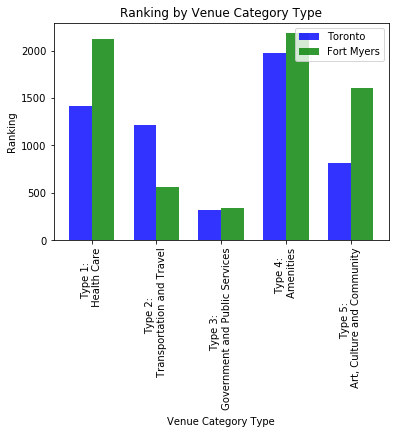

<Figure size 1440x216 with 0 Axes>

In [46]:
# Comparing the result of ranking for the 2 cities
xticklabels=['Type 1: \n Health Care', 'Type 2: \n Transportation and Travel', 
                    'Type 3: \n Government and Public Services', 'Type 4: \n Amenities',
                    'Type 5: \n Art, Culture and Community']

plotBar(toronto_types_ranking, fm_types_ranking, 'Toronto', 'Fort Myers', xticklabels)

print()
print()

Result of the first analysis is showing in the aforementioned bar chart. Both cities are performing better to their counterparts in some areas. 
To summarize the finding, Fort Myers is winning in Health Care and Art, Culture and Community, while Toronto is surpressing Fort Myers in Transportation and Travel. Both cities are comparable in Governemnt and Public Services and Amenties categories.

Therefore, we can conclude that Fort Myers overtook Toronto in the contest of being the best retirement community in the North America region, though only winning by a nose. 
Please note that the result of the above analysis does not necessary mean that Toronto is bad in any aspects, given that Fort Myers is only winning in a narrow margin, and Toronto even ties or wins in some categories.

### Remarks: Getting the full category list from the Foursquare API

In [ ]:
categoryrequest = ''
cat_list = []
    
categoryUrl = 'https://api.foursquare.com/v2/venues/categories?&client_id={}&client_secret={}&v={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET,
        VERSION)

categoryResults = requests.get(categoryUrl).json()['response']['categories']

def GetCategory(category):
    for c in category:
        cat_list.append(c['name'])
        for cn in c['categories']:
            cat_list.append(cn['name'])
            if(len(cn['categories']) > 0):
                GetCategory(cn['categories'])
    return cat_list

GetCategory(categoryResults)

all_categories = pd.DataFrame(cat_list)
all_categories.columns = ['Category']
# all_categories.to_csv('all_categories.csv', sep=',')


This is the end of the notebook.